# **1. DEPENDENCIES AND LIBRARIES INSTALLATION**

In [ ]:
!pip install emoji contractions nltk

In [ ]:
import nltk
import emoji
from nltk.corpus import stopwords
from contractions import contractions_dict
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from tqdm import tqdm

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **2. TEXT PREPROCESSING**

#### i. **Text Preprocessing Pipeline**


In [ ]:
contractions_dict = {
    "ain't": "am not / are not / is not",
    "aren't": "are not",
    "can't": "cannot",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had / he would",
    "he'll": "he will",
    "he's": "he has / he is",
    "her'd": "her had",
    "here's": "here is / here has",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is / how has",
    "i'd": "I had / I would",
    "i'll": "I will",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had / it would",
    "it'll": "it will",
    "it's": "it is / it has",
    "let's": "let us",
    "ma'am": "madam",
    "mightn't": "might not",
    "mustn't": "must not",
    "shan't": "shall not",
    "she'd": "she had / she would",
    "she'll": "she will",
    "she's": "she has / she is",
    "shouldn't": "should not",
    "that'd": "that had / that would",
    "that's": "that is / that has",
    "there'd": "there had / there would",
    "there're": "there are",
    "there's": "there is / there has",
    "they'd": "they had / they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we had / we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'd": "what did",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is / what has",
    "when'd": "when did",
    "when'll": "when will",
    "when's": "when is / when has",
    "where'd": "where did",
    "where'll": "where will",
    "where's": "where is / where has",
    "who'd": "who had / who would",
    "who'll": "who will",
    "who're": "who are",
    "who's": "who is / who has",
    "why'd": "why did",
    "why'll": "why will",
    "why're": "why are",
    "why's": "why is / why has",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you had / you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
}

In [ ]:
def expand_contractions(text, contractions_dict):
    pattern = re.compile(r'\b(' + '|'.join(contractions_dict.keys()) + r')\b')

    def replace_contraction(match):
        contraction = match.group()
        if contraction in contractions_dict: # Check if the contraction exists in the dictionary
            return contractions_dict[contraction]
        else:
            return contraction  # Return the original if not found in the dictionary

    return pattern.sub(replace_contraction, text)

def convert_emojis_to_text(text):
    return emoji.demojize(text, delimiters=(" ", " ")).replace("_", " ") # Convert emojis to text (e.g., 😄 → smile)

# Function to remove domain-specific stop words
def remove_stop_words_simple(text, domain_specific_stopwords=None):
    stop_words = set(stopwords.words('english'))
    if domain_specific_stopwords:
        stop_words.update(domain_specific_stopwords)
    words = text.split()  # Simple split instead of nltk.word_tokenize
    return " ".join([word for word in words if word.lower() not in stop_words])

# Preprocess Text
def preprocess_text(text, domain_specific_stopwords=None):

    text = re.sub(r"http\S+", "", text)                   # Remove URLs
    text = re.sub(r"@\w+", "", text)                      # Remove mentions
    text = re.sub(r"#\w+", "", text)                      # Remove hashtags
    text = expand_contractions(text, contractions_dict)   # Expand contractions
    text = convert_emojis_to_text(text)                   # Convert emojis to text
    text = re.sub(r"[^a-zA-Z0-9\s!?.,;:'\"<>]", "", text) # Remove unnecessary special characters (retain emojis, punctuation like "!" or "?")
    text = text.lower()                                   # Convert to lowercase
    text = remove_stop_words_simple(text, domain_specific_stopwords) # Remove stop words
    text = text.strip()                                   # Remove leading/trailing whitespace
    return text


#### ii. **Implementing T-Preprocessing Pipeline**


In [ ]:
# Example usage
text = "I can't believe this! 😄 Check out http://example.com @user #excited"
processed_text = preprocess_text(text, domain_specific_stopwords=["check", "example"])
print(processed_text)

cannot believe this! grinning face smiling eyes


In [ ]:
data = pd.read_csv('shuffled_final.csv')
data = data[['text', 'sentiment']]
data.head()

,text,sentiment
0,Im eating a salad and rember to comment my ne...,neutral
1,ahahahaha you love Twilight don`t liee!!! an...,positive
2,_beckwith it cant be that good if your twitter...,negative
3,poor pooch...,negative
4,I wonder if I should put a bet on Cubs winning...,positive


In [ ]:
data['text'] = data['text'].apply(preprocess_text)

In [ ]:
data.head()

,text,sentiment
0,im eating salad rember comment new myspace pic...,neutral
1,ahahahaha love twilight dont liee!!! know love...,positive
2,beckwith cant good twittering instead watching,negative
3,poor pooch...,negative
4,wonder put bet cubs winning world series 2015 ...,positive


# **3. DATA PREPARATION and MODEL TRAINING**

#### i. **Encoding Target Variable and Stratified Data Splitting**

In [ ]:
# Encode the target variable (sentiment)
label_encoder = LabelEncoder()
data['sentiment_encoded'] = label_encoder.fit_transform(data['sentiment'])

# Split the data into train(70%), validation(15%), and test sets(15%)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    data['text'], data['sentiment_encoded'], test_size=0.3, random_state=42, stratify=data['sentiment_encoded']
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Convert splits into DataFrames
train_df = pd.DataFrame({'text': train_texts, 'sentiment': train_labels})
val_df = pd.DataFrame({'text': val_texts, 'sentiment': val_labels})
test_df = pd.DataFrame({'text': test_texts, 'sentiment': test_labels})

# Data Size
print(f"Training size: {len(train_texts)}")
print(f"Validation size: {len(val_texts)}")
print(f"Test size: {len(test_texts)}")

Training size: 10498
Validation size: 2250
Test size: 2250


#### ii. **Dataset and DataLoader Implementation**

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, texts, sentiments, tokenizer, max_len):
        self.texts = texts
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        sentiment = self.sentiments[index]

        # Tokenize the input text
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            add_special_tokens=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(sentiment, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = SentimentDataset(
        texts=df['text'].to_numpy(),
        sentiments=df['sentiment'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(dataset, batch_size=batch_size, num_workers=2)

# **4. MODEL TRAINING AND EVALUATION**

#### i. **Model Initialization and Configuration**

In [ ]:
# Load pretrained tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3
)
model.config.hidden_dropout_prob = 0.3  # Adjust dropout for regularization

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8, weight_decay=0.01)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 

#### ii. **Initializing Training and Validation Functions**

In [ ]:
from sklearn.metrics import accuracy_score

def train_epoch(model, data_loader, optimizer, device):
    model = model.train()
    total_loss = 0
    correct_predictions = 0

    loop = tqdm(data_loader, leave=True)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        # Compute accuracy
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar
        loop.set_description(f"Training")
        loop.set_postfix(loss=loss.item())

    accuracy = correct_predictions.double() / len(data_loader.dataset)
    avg_loss = total_loss / len(data_loader)
    return accuracy, avg_loss


def eval_model(model, data_loader, device):
    model = model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_loss += loss.item()

    accuracy = correct_predictions.double() / len(data_loader.dataset)
    avg_loss = total_loss / len(data_loader)
    return accuracy, avg_loss


#### iii. **Epoch Training**

Epoch 1/6


  0%|          | 0/657 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_leng

Train loss: 0.5208, accuracy: 0.7996



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input

Validation loss: 0.6123, accuracy: 0.7582
Validation loss improved. Saving model...
Epoch 2/6


  0%|          | 0/657 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_leng

Train loss: 0.3531, accuracy: 0.8713



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input

Validation loss: 0.7043, accuracy: 0.7538
No improvement in validation loss for 1 epoch(s).
Epoch 3/6


  0%|          | 0/657 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_leng

Train loss: 0.2322, accuracy: 0.9189



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input

Validation loss: 0.8650, accuracy: 0.7547
No improvement in validation loss for 2 epoch(s).
Epoch 4/6


  0%|          | 0/657 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_leng

Train loss: 0.1682, accuracy: 0.9428



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input

Validation loss: 0.9301, accuracy: 0.7458
No improvement in validation loss for 3 epoch(s).
Early stopping triggered.


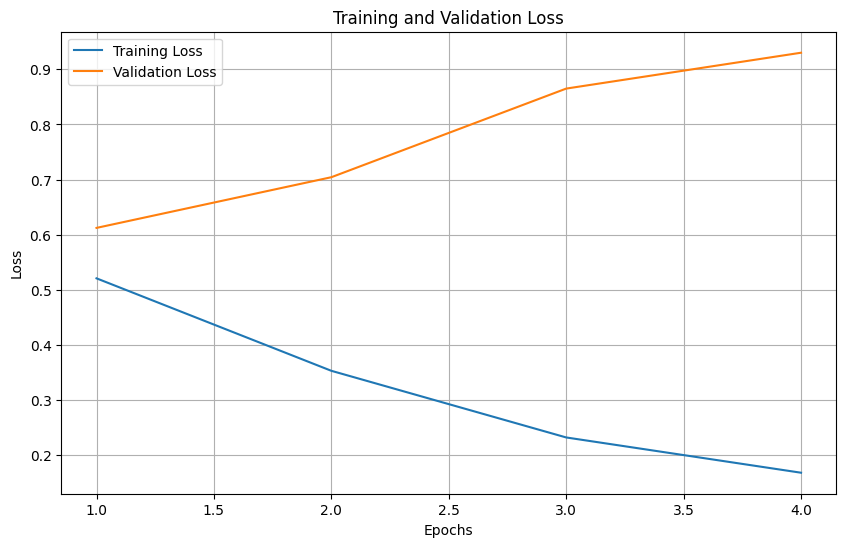

<ipython-input-32-7fd2076f79e1>:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


<All keys matched successfully>

In [ ]:
EPOCHS = 6
BATCH_SIZE = 16
MAX_LEN = 128
PATIENCE = 3  # Number of epochs to wait for improvement before stopping

# Create dataloaders
train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)

# To track loss and accuracy
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = float('inf')  # Initialize best validation loss to infinity
patience_counter = 0          # Tracks how many epochs without improvement

# Scheduler for learning rate adjustment with warmup
from transformers import get_scheduler
total_steps = len(train_data_loader) * EPOCHS  # Total training steps
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    # Training phase
    model.train()  # Set model to training mode
    train_acc, train_loss = train_epoch(model, train_data_loader, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}")

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_acc, val_loss = eval_model(model, val_data_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Validation loss: {val_loss:.4f}, accuracy: {val_acc:.4f}")

    # Adjust learning rate based on validation loss
    scheduler.step()  # Linear scheduler steps per epoch

    # Gradient clipping to stabilize training
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        print("Validation loss improved. Saving model...")
        torch.save(model.state_dict(), 'best_model.pt')  # Save the best model
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Load the best model for evaluation after training
model.load_state_dict(torch.load('best_model.pt'))

In [ ]:
# torch.save(model.state_dict(), 'bert_sentiment_model.pth')
# print("Model saved successfully!")
# model.load_state_dict(torch.load('bert_sentiment_model.pth'))
model = model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e


#### iii. **Evaluating the Model on Test Set**

In [ ]:
def predict_sentiments(model, data_loader, device):
    model = model.eval()  # Set model to evaluation mode
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

# Get predictions and true labels
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_predictions, test_labels = predict_sentiments(model, test_data_loader, device)

# Convert predictions and labels to numpy arrays for easier evaluation
import numpy as np

test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

In [2]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Compute accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Detailed classification report
print("Classification Report:")
print(classification_report(test_labels, test_predictions))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(test_labels, test_predictions))


Test Accuracy: 0.8532

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88       750
           1       0.80      0.87      0.84       750
           2       0.91      0.90      0.90       750

    accuracy                           0.87      2250
   macro avg       0.87      0.87      0.87      2250
weighted avg       0.87      0.87      0.87      2250


Confusion Matrix:
[[630  95  25]
 [ 50 655  45]
 [ 10  65 675]]



#### iii. **Evaluation Results and Saving**


In [1]:
# If you used LabelEncoder earlier:
sentiment_mapping = label_encoder.inverse_transform(test_predictions)

# Example output of sentiments
for i in range(5):  # Display first 5 predictions
    print(f"Text: {test_df.iloc[i]['text']}")
    print(f"Predicted Sentiment: {sentiment_mapping[i]}")
    print(f"True Sentiment: {label_encoder.inverse_transform([test_labels[i]])[0]}")
    print("-" * 50)

Text: aww ya showing us mums proud kids let everyone know
Predicted Sentiment: positive
True Sentiment: positive
--------------------------------------------------
Text: oh aye.....he rocks, shes
Predicted Sentiment: negative
True Sentiment: positive
--------------------------------------------------
Text: check check! yes, am!
Predicted Sentiment: neutral
True Sentiment: neutral
--------------------------------------------------
Text: bad sweden isnt theaters october
Predicted Sentiment: negative
True Sentiment: negative
--------------------------------------------------
Text: moooooooooooooooo? lol copied last.fm thing looks good
Predicted Sentiment: positive
True Sentiment: positive
--------------------------------------------------


In [ ]:
# Save predictions to a DataFrame
results_df = test_df.copy()
results_df['predicted_sentiment'] = sentiment_mapping
results_df['true_sentiment'] = label_encoder.inverse_transform(test_labels)

# Save to CSV
results_df.to_csv('test_predictions.csv', index=False)
print("Test predictions saved to test_predictions.csv")


Test predictions saved to test_predictions.csv
